In [1]:
using FileIO
using Plots
include("splitcell.jl")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageSegmentation [80713f31-8817-5129-9cf8-209ff8fb23e1]
└ @ Base loading.jl:1260


remove_small_area

In [210]:
include("segmentation3d.jl")
include("normalization3d.jl")

normalize (generic function with 1 method)

In [2]:
d16s1 = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s1.ome.tiff"));

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1260


In [3]:
@time mask_markers_2  = split_cell_LoG(d16s1, 138);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 239.338087 seconds (32.63 M allocations: 63.491 GiB, 11.69% gc time)


In [299]:
# Get living time
livingtime(stack) = [ sum(stack[:, :, i])>0 for i in 1:size(stack)[3] ]
area_t(stack) = [ sum(stack[:, :, i]) for i in 1:size(stack)[3] ]
"""
function component_lengths(img::AbstractArray{Int})
    n = zeros(Int64,maximum(img)+1)
    for i=1:length(img)
        n[img[i]+1]+=1
    end
    n
end
"""

# Find long-lived trajactory
function find_time_line(markers_t)
    # search connected components in 3D space 
    shortest_t = 90
    print("Finding connected component")
    @time time_line = label_components( markers_t.>0 )
    line_amount = maximum(time_line)
    # More advanced and fine punch and merge could be done
    # But we just select long living trajactory, remove short-lived one
    living_time =[ livingtime(time_line.==line) for line in 1:line_amount ]
    living_length = [sum(living_time[line]) for line in 1:line_amount]
    # label 0 mean background
    shortlived = living_length .< shortest_t
    longlived_label = (1:line_amount)[.~shortlived]
    #longlived_time = living_time[]
    for line in (1:line_amount)[shortlived]
        time_line .*= (time_line.≠line)
    end
    time_line, longlived_label, living_time[longlived_label], time_line_whole
end

find_time_line (generic function with 1 method)

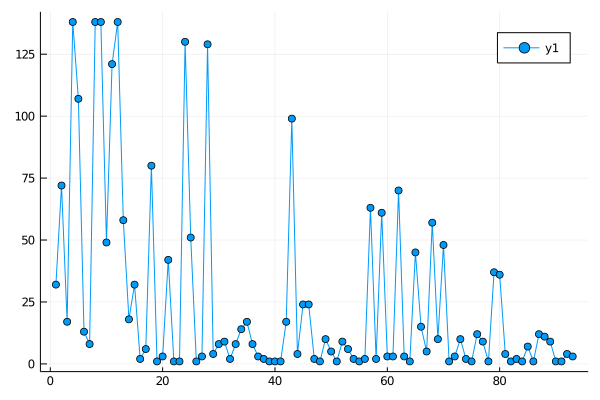

In [56]:
@time time_line, longlived_label, livetime = find_time_line(mask_markers);
plot(sum.(livetime), marker=:circle)

In [5]:
@time time_line_2, longlived_label_2, livingtime_2 = find_time_line(mask_markers_2);

Finding connected component  3.705766 seconds (154.82 k allocations: 2.906 GiB, 1.02% gc time)
 98.942287 seconds (6.37 M allocations: 12.924 GiB, 1.15% gc time)


In [63]:
for i in longlived_label_2
    #save("d16s1_$i.tiff", d16s1[:, :, 14:20:end] .*(time_line_2 .== i))
    #print("saving $i")
end 

saving 4saving 5saving 8saving 9saving 11saving 12saving 13saving 15saving 27saving 31saving 53

In [12]:
@time area_longlived = [area_t( time_line_2 .== i)  for i in longlived_label_2];

  4.457932 seconds (219.41 k allocations: 1.042 GiB, 1.46% gc time)


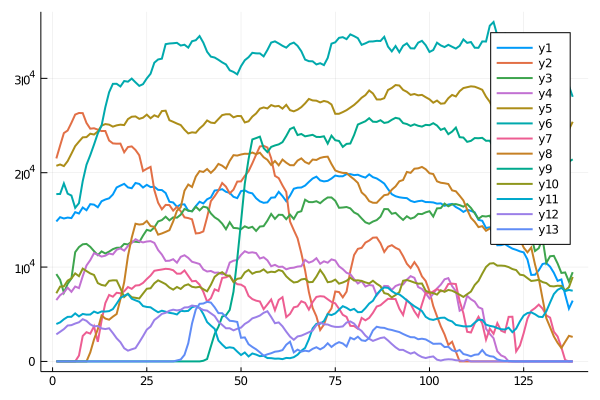

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [20]:
plot(area_longlived, lw=2)

In [175]:
time_line_2_old = copy(time_line_2)
longlived_label_2_old = copy(longlived_label_2 )
livingtime_2_old = copy(livingtime_2);

11-element Array{Array{Bool,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [236]:
time_line_2 = copy(time_line_2_old)
longlived_label_2 = copy(longlived_label_2_old )
livingtime_2 = copy(livingtime_2_old);

In [6]:
function get_unique_label(_old_labels)
    i = 100 # start from 100 to distiguish with oldest labels
    while(true)
        if i in _old_labels
            i+=1
        else
            break
        end
    end
    i
end

get_unique_label (generic function with 1 method)

In [7]:
#for old_label in old_labels
function split_contacted_cell!(old_time_line::Array{Int64,3}, 
        old_longlived_labels::Array{Int64,1}, old_living_time::Array{Array{Bool,1},1})
    t_len = size(old_time_line)[3]
    println("Detecting contacted branch")
    conn_z_number = []; # mark connected components more than 1
    for label in old_longlived_labels
        branches = time_line_2 .== label
        push!(conn_z_number, [maximum(label_components(branches[:,:, i])) .> 1 for i in 1:t_len])
    end
    contacted_labels = old_longlived_labels[sum.(conn_z_number) .> 10]
    print("Found contacted branch: ")
    println(contacted_labels)
    # if two more connected component touch to at same z slice more than 10 times
    # select area longer than 5e4
    #old_label = longlived_label_2[mean.(area_longlived) .> 5e4 ]
    
    # split 3d branch by split 2d cell slice by slice
    for contacted_label in contacted_labels
        dist_const = 30 # distance constant 
        contacted_branch = old_time_line .==  contacted_label
        dist  = zeros(size( contacted_branch ))
        local_markers = zeros(Bool, size( contacted_branch ))
        println("Splitting branch $contacted_label now")
        for  t in 1:t_len
            dist[:,:, t] = distance_transform(feature_transform(.~contacted_branch[:,:,t]))
            local_markers[:,:,t] = dist[:,:,t] .> dist_const
            #split_water = watershed( .- dist[:,:,t], label_components(markers[:,:,t]))
            # 直接用 dist 可能会错误打断完整轨迹，需额外膨胀
            # 用分水岭 可能会误连，需额外腐蚀
        end
        local_time_line, local_longlived_labels, local_living_time = find_time_line( local_markers );
        println("Reassigning contacted branch $contacted_label ")
        # Assign new label to labels set and update mask
        
        if length(local_longlived_labels) > 0
            #TODO: what if all lines are shorter than 90 after breaking
            # remove old branch, old label, old living time.
            old_time_line .-= (( old_time_line .== contacted_label ).*contacted_label)
            index2remove =  old_longlived_labels .== contacted_label
            deleteat!( old_longlived_labels, index2remove )
            deleteat!( old_living_time, index2remove)
            for i in 1:length(local_longlived_labels)
                global_label = get_unique_label(old_longlived_labels)
                old_time_line .+= ((local_time_line .== local_longlived_labels[i]) .* global_label)
                push!( old_longlived_labels, global_label )
                push!( old_living_time, local_living_time[i] )
                println("Branch $contacted_label -> $global_label")
            end
        end
    end
    # Should we return area_t rather than area_t.>0
    old_time_line, old_longlived_labels, old_time_line
end

split_contacted_cell! (generic function with 1 method)

In [8]:
@time split_contacted_cell!(time_line_2, longlived_label_2, livingtime_2);

Detecting contacted branch
Found contacted branch: [8, 13]
Splitting branch 8 now
Finding connected component  2.614129 seconds (72 allocations: 2.897 GiB, 1.00% gc time)
Reassigning contacted branch 8 
Branch 8 -> 100
Branch 8 -> 101
Branch 8 -> 102
Splitting branch 13 now
Finding connected component  2.480429 seconds (70 allocations: 2.897 GiB, 0.40% gc time)
Reassigning contacted branch 13 
Branch 13 -> 103
140.381769 seconds (6.56 M allocations: 70.160 GiB, 3.90% gc time)


In [9]:
save("splitcell_test.jld", "time_line", time_line_2, "longlived_labels",
    longlived_label_2,"livingtime", livingtime_2);

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1260


In [224]:
for i in 100:103
    save("d16s1_$i.tiff", d16s1[:, :, 14:20:end] .*(time_line_2 .== i))
    println("saving $i")
end 

saving 100
saving 101
saving 102
saving 103


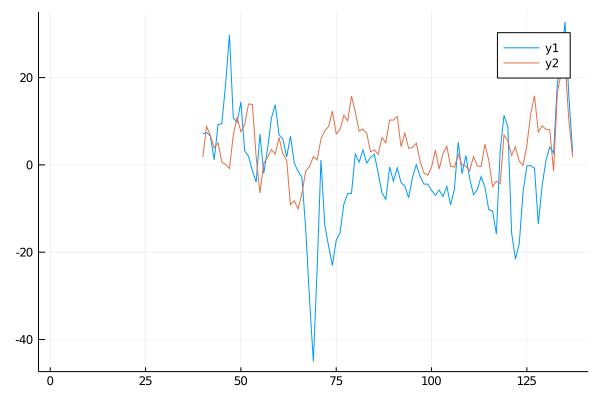

In [187]:
label = 9
test = centroids[:, 2:end, label].- centroids[:, 1:end-1, label]
plot(test[1,:])
plot!(test[2,:])

In [9]:
"`component_centroids(labeled_array)` -> an array of centroids for selected lables, excluding the background label 0"
function component_centroids_lables(img::AbstractArray{Int,N}, labels::AbstractArray{Int, 1}) where N
    len = length(0:maximum(labels))
    n = fill(zero(CartesianIndex{N}), len)
    counts = fill(0, len)
    @inbounds for I in CartesianIndices(size(img))
        v = img[I] + 1
        n[v] += I
        counts[v] += 1
    end
    map(v -> n[v].I ./ counts[v], labels.+1)
end

"extract walking pathway"
function walking(_time_line, _longlived_labels, _livingtime)
    _tracks = zeros( 2, length(_livingtime[1]), length(_longlived_labels))
    @inbounds for t in 1: length(_livingtime[1])
        tmp = component_centroids_lables(_time_line[:, :, t], _longlived_labels)
        @inbounds for i in 1:length(_longlived_labels)
            _tracks[:, t, i] = [tmp[i][1]  tmp[i][2]]
        end
    end
    _tracks #[pos, t, branch]
    #TODO: soomth pathway to make sence in biology
end

walking

In [182]:
" Return box with fixed height and width"
function box(_center, _d₁max, _d₂max)
    α = 256 
    Α = 2*α 
    d₁, d₂ = Int.(floor.(_center))
    d₁min, d₁max, d₂min, d₂max = d₁-α+1, d₁+α,  d₂-α+1, d₂+α
    if d₁min < 1
        d₁max = Α
        d₁min = 1
    end
    if d₁max > _d₁max
        d₁min = _d₁max - Α + 1
        d₁max = _d₁max 
    end
    if d₂min < 1
        d₂max = Α
        d₂min = 1
    end
    if d₂max > _d₂max
        d₂min = _d₂max - Α + 1
        d₂max = _d₂max
    end
    d₁min:d₁max, d₂min:d₂max
end
"""
Using given mask to export roi of cell 
"""
function pick_cells( _raw_imgs, _time_line, _longlived_labels, _livingtime)

    z_depth = 20
    t_len = length(_livingtime[1])
    height, width = size(_raw_imgs[:,:,1]);
    watershed_imgs = zeros(height, width, t_len)
    crop_imgs = []
    # watershed here?
    println("Expand and split slice region by watershed")
    #@inbounds for t in 1:t_len # TODO: mulit-thread
    #    print("$t ")
    #    watershed_imgs[:, :, t] = labels_map(watershed(
    #            .-maximum(_raw_imgs[:,:,z_depth*(t-1)+1:z_depth*t],dims=3)[:,:,1], _time_line[:,:,t]) )
    #end
    
    
    # Get centroids for each label
    tracks = walking(_time_line, _longlived_labels, _livingtime)
    println("Split celles single")
    @inbounds for i in 1:length(_longlived_labels)
        crop_img = zeros(512, 512, t_len*z_depth)
        label = _longlived_labels[i]
        print("$label ")
        for t in (1:t_len)[_livingtime[i]] # only choose frame when object exist
            bounder = box(tracks[:, t, i], height, width)
            crop_img[:, :, (t-1)*z_depth+1:t*z_depth] = 
                _raw_imgs[bounder[1], bounder[2], (t-1)*z_depth+1:t*z_depth] .*
                (_time_line[bounder[1], bounder[2], t] .== label)
                #(watershed_imgs[bounder[1], bounder[2], t] .== label)
        end
        push!(crop_imgs, crop_img)
    end
    #crop_imgs, Dict("tracks"=>tracks, "watershed"=>watershed_imgs)
    crop_imgs, Dict("tracks"=>tracks)
end

pick_cells

In [ ]:
function exportcell()
    
end

In [ ]:
@time d16s1_cel, para = pick_cells(d16s1, time_line_2, longlived_label_2, livingtime_2);

Expand and split slice region by watershed
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 

In [183]:
@time d16s1_cel_direct, para_2 = pick_cells(d16s1, time_line_2, longlived_label_2, livingtime_2);

Expand and split slice region by watershed
Split celles single
4 5 9 11 12 15 27 31 53 100 101 102 103 141.660951 seconds (672.21 k allocations: 109.847 GiB, 4.31% gc time)


In [100]:
yen = yen_threshold(d16s1_cel[6][:,:,20*16+1:20*17])

┌ Warning: `imhist` will be removed in a future release, please use `build_histogram` instead.
│   caller = yen_threshold(::Array{Float64,3}, ::Int64) at algorithms.jl:845
└ @ Images /home/hf/.julia/packages/Images/7IWP4/src/algorithms.jl:845


0.002732142830428883

In [156]:
img = mapwindow(median!, maximum(d16s1_cel[6][:,:,20*16+1:20*17], dims=3)[:,:,1], (5,5));

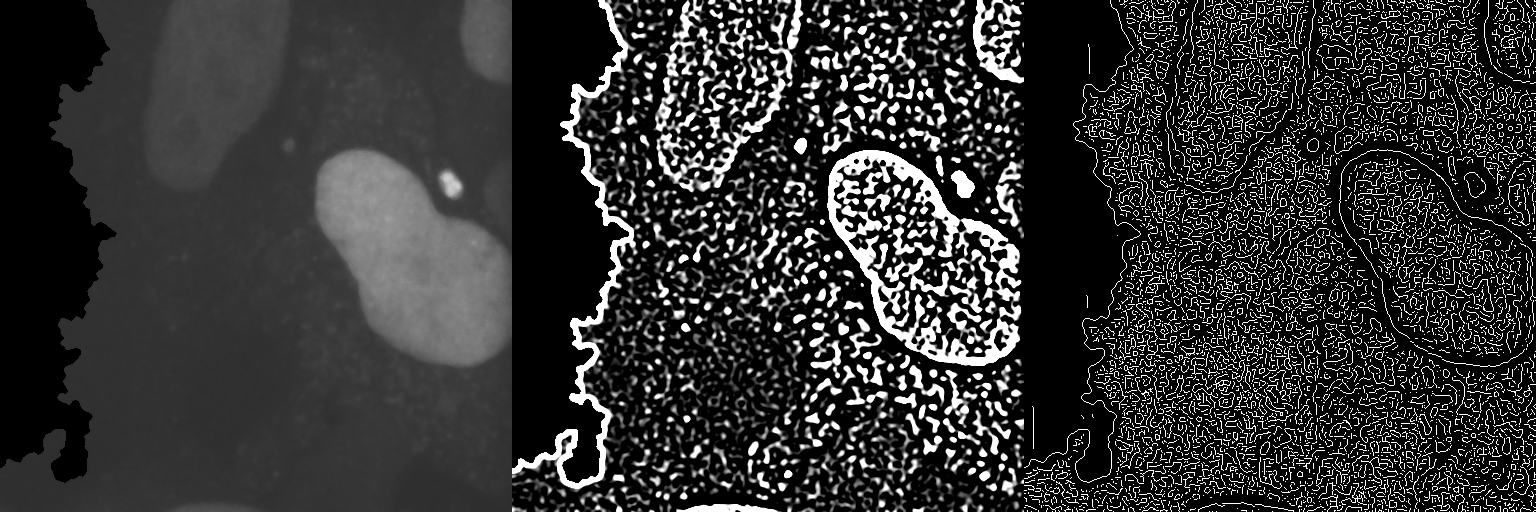

In [175]:
[Gray.(img.*100) Gray.(imfilter(img, Kernel.DoG(2)).*100000) Gray.(time_line_2[]) ] 

In [296]:
x.image_indexmap

512×512 Array{Int64,2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  

In [233]:
rage_6_16 = box(para["tracks"][:,16, 6], 1900, 1300);

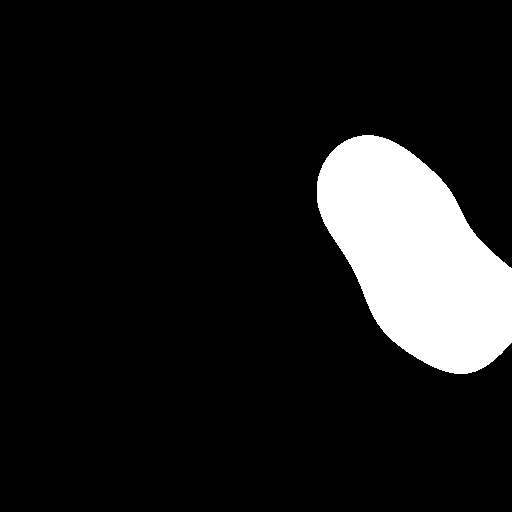

In [236]:
mask_6_16 =(time_line_2[:,:, 16] .== longlived_label_2[6])[rage_6_16[1], rage_6_16[2]]
Gray.((time_line_2[:,:, 16] .== longlived_label_2[6])[rage_6_16[1], rage_6_16[2]])

In [271]:
 0.002*0xffff

131.07

In [273]:
findlocalmaxima(hmin_transform(img, 0.002))

1926-element Array{CartesianIndex{2},1}:
 CartesianIndex(512, 1)
 CartesianIndex(512, 3)
 CartesianIndex(512, 9)
 CartesianIndex(137, 58)
 CartesianIndex(108, 63)
 CartesianIndex(120, 68)
 CartesianIndex(141, 68)
 CartesianIndex(144, 69)
 CartesianIndex(135, 71)
 CartesianIndex(100, 72)
 CartesianIndex(108, 73)
 CartesianIndex(104, 75)
 CartesianIndex(116, 75)
 ⋮
 CartesianIndex(209, 507)
 CartesianIndex(376, 507)
 CartesianIndex(21, 508)
 CartesianIndex(169, 508)
 CartesianIndex(229, 508)
 CartesianIndex(307, 508)
 CartesianIndex(185, 509)
 CartesianIndex(43, 511)
 CartesianIndex(422, 511)
 CartesianIndex(18, 512)
 CartesianIndex(164, 512)
 CartesianIndex(188, 512)

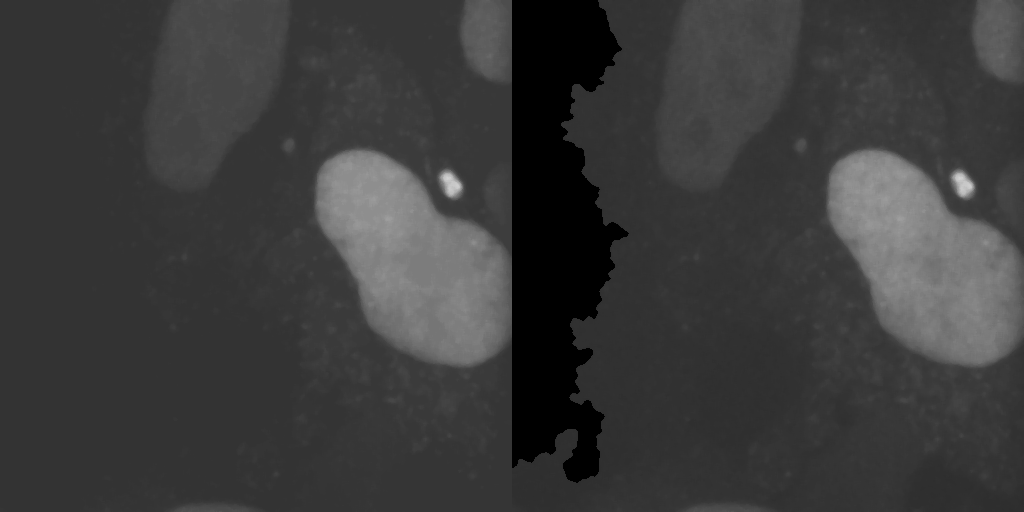

In [272]:
[Gray.(hmin_transform(img, 0.002).*100) Gray.(img.*100)]

In [ ]:
watershed(.-img, )

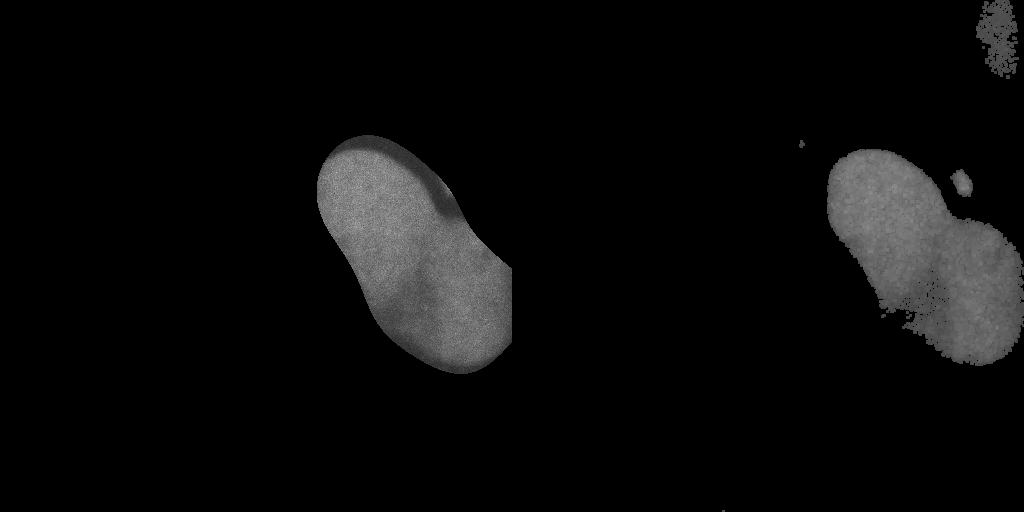

In [238]:
[Gray.(d16s1_cel[6][:, :, 20*16+14].*100 .*mask_6_16) Gray.(opening(d16s1_cel[6][:, :, 20*16+14] .* (d16s1_cel[6][:,:,20*16+14].>yen) ).*100 ) ]

In [211]:
@time nucleus, thres = extract3dnucleus(d16s1_cel_direct[1]);

119.954822 seconds (3.66 M allocations: 32.789 GiB, 32.56% gc time)


In [213]:
include("tiffxml.jl")

embedxml

In [215]:
save("d16s1_1_3d.tiff", N0f16.(nucleus))
embedxml(512, 512, 20, 138, "d16s1_1_3d.tiff")

Embedding OME-XML    1 image files updated


In [244]:
mask6_16_3d = zeros(512, 512, 20)
for i in 1:20
    mask6_16_3d[:,:,i] =mask_6_16
end

In [219]:
norm, para_norm = normalize(nucleus)
save("d16s1_1_3d_nor.tiff", N0f16.(norm))
embedxml(512, 512, 20, 138, "d16s1_1_3d_nor.tiff")

Embedding OME-XML    1 image files updated


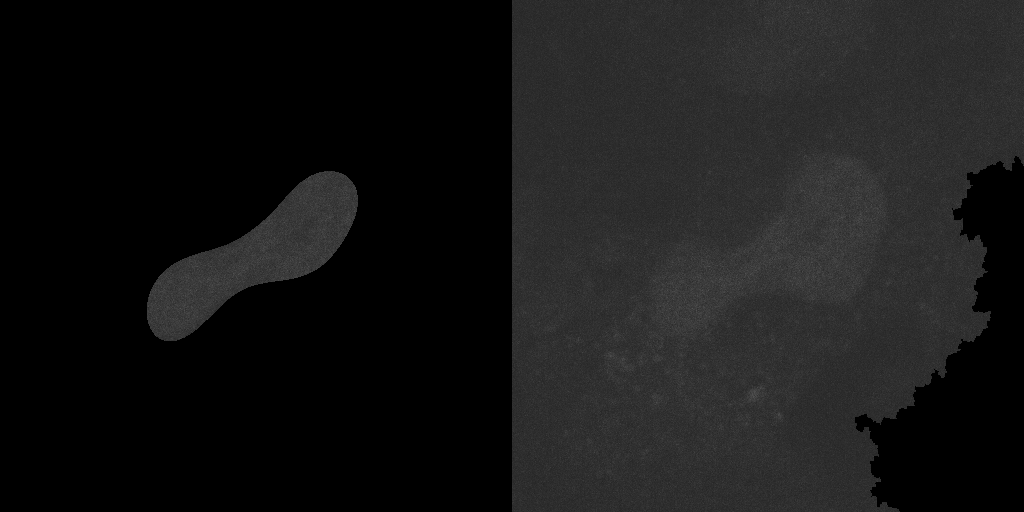

In [205]:
[Gray.(d16s1_cel_direct[1][:,:,15].*100) Gray.(d16s1_cel[1][:,:,15].*100)]

In [199]:
for i in 1:length(longlived_label_2)
    print("saving $(longlived_label_2[i]) ")
    save("d16_s1-$(longlived_label_2[i]).tiff", N0f16.(d16s1_cel_direct[i]))
end

saving 4 saving 5 saving 9 saving 11 saving 12 saving 15 saving 27 saving 31 saving 53 saving 100 saving 101 saving 102 saving 103 

""

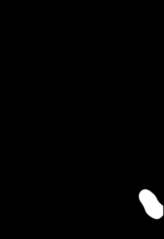

In [181]:
[ Gray.(time_line_2[:, :, 16].==longlived_label_2[6]) ]

In [184]:
maximum(d16s1_cel[13][:, :, 14+20*3])

0.0

In [153]:
d1, d2 = Int.(floor.(centroids[:, 1, 12]))

2-element Array{Int64,1}:
  564
 1160

In [167]:
box_1 = box(centroids[:, 1, 12], 1900, 1300)

(213:914, 601:1300)

""

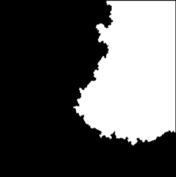

In [248]:
[Gray.(watertest.image_indexmap[box_1[1], box_1[2]].==102)] #Gray.(watertest.image_indexmap .==label) Gray.(time_line_2[:,:, 1] .==label) ]